# **Projeto Nanodegree: Combatendo a Evasão de Alunos com Machine Learning & Inteligência Artificial**

**Equipe:** Marcos Bristot, Raul Werner, Guilherme Baschera e Charles Savadinscky 

### **Nossa Missão**
A organização educacional PensComp oferece cursos de alta qualidade, mas enfrenta um grande desafio: muitos alunos desistem no meio do caminho. Nossa missão neste projeto foi utilizar dados e Machine Learning para criar uma ferramenta capaz de **prever quais estão em risco de evasão**, permitindo que a equipe pedagógica atue de forma preventiva e personalizada para ajudá-los a concluir o curso.

In [48]:
# ==============================================================================
# 1. CONFIGURAÇÃO E CARGA
# ==============================================================================
# Instalação de dependências e importação de bibliotecas
# pip install -q openpyxl shap

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import shap
import tensorflow as tf
from tensorflow import keras

# Imports do Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, 
                             ConfusionMatrixDisplay, roc_curve)

# Configurações de visualização e reprodutibilidade
pd.set_option('display.max_columns', None)
tf.random.set_seed(42)

print("--- Ambiente Configurado e Bibliotecas Carregadas ---")

# Carregamento dos dados
try:
    df_variaveis = pd.read_excel('lista_variaveis.xlsx')
    df_treino = pd.read_csv('dados_projeto_evasao_treino.csv')
    df_teste = pd.read_csv('dados_projeto_evasao_teste.csv')
    print("✅ Arquivos carregados com sucesso!")
except Exception as e:
    print(f"❌ ERRO ao carregar os arquivos: {e}")

--- Ambiente Configurado e Bibliotecas Carregadas ---
✅ Arquivos carregados com sucesso!


## **Etapa 2: Definição Estratégica e Limpeza dos Dados**

Nesta etapa crucial, definimos nosso alvo e fizemos uma limpeza estratégica nos dados, com duas decisões importantes:

1.  **Engenharia da Variável-Alvo:** Como não havia uma coluna "evadiu", criamos a nossa com base na regra de negócio de que um aluno inativo há mais de 30 dias é considerado evadido.
2.  **Foco em Engajamento:** Decidimos estrategicamente **remover todas as variáveis baseadas puramente em tempo** (como `nr_dias_desde_primeiro_acesso`). Embora sejam fortes preditores, elas podem mascarar os verdadeiros comportamentos dos alunos. Nossa meta é criar um modelo que forneça insights sobre o **engajamento**, que é algo que a equipe pedagógica pode de fato influenciar.

Também removemos colunas com excesso de dados nulos e outras que não agregam valor.

In [49]:
# Guarda o número de linhas antes da remoção
linhas_antes = df_treino.shape[0]

# Filtra o DataFrame, mantendo apenas as linhas onde 'ts_primeiro_acesso' é diferente de 0
# e reatribui o resultado à mesma variável.
df_treino = df_treino[df_treino['ts_primeiro_acesso'] != 0]

# Guarda o número de linhas após a remoção
linhas_depois = df_treino.shape[0]

print(f"Remoção concluída com sucesso!")
print(f"Número de linhas antes: {linhas_antes}")
print(f"Número de linhas agora: {linhas_depois}")
print(f"Total de {linhas_antes - linhas_depois} linhas removidas.")

Remoção concluída com sucesso!
Número de linhas antes: 400
Número de linhas agora: 205
Total de 195 linhas removidas.


In [50]:
# ==============================================================================
# 2. LIMPEZA ESTRATÉGICA E ENGENHARIA DE ATRIBUTOS
# ==============================================================================

# 2.1. Engenharia da Variável-Alvo
DIAS_PARA_EVASAO = 30
df_treino['target_evadiu'] = (df_treino['nr_dias_desde_ultimo_acesso'] > DIAS_PARA_EVASAO).astype(int)
df_teste['target_evadiu'] = (df_teste['nr_dias_desde_ultimo_acesso'] > DIAS_PARA_EVASAO).astype(int)
print("✅ Coluna 'target_evadiu' criada com sucesso.")

# 2.2. Definição e Remoção de Colunas Indesejadas
# Colunas com alta taxa de valores nulos
LIMIAR_PARA_REMOVER = 70.0
missing_percentage = (df_treino.isnull().sum() / len(df_treino)) * 100
colunas_com_nulos = missing_percentage[missing_percentage > LIMIAR_PARA_REMOVER].index.tolist()

# Colunas de tempo (decisão estratégica)
variaveis_de_tempo = ['nr_dias_desde_primeiro_acesso', 'nr_intervalos_uso', 'nr_dias_uso']

# Colunas de ID ou que vazam informação
outras_colunas = ['Unnamed: 0', 'ts_primeiro_acesso', 'ts_ultimo_acesso', 'nr_dias_desde_ultimo_acesso']

# Juntar todas as colunas a serem removidas
colunas_para_remover = colunas_com_nulos + variaveis_de_tempo + outras_colunas
colunas_existentes_para_remover = [col for col in colunas_para_remover if col in df_treino.columns]

# Aplicar a remoção
df_treino_final = df_treino.drop(columns=colunas_existentes_para_remover)
df_teste_final = df_teste.drop(columns=colunas_existentes_para_remover)



print(f"\n✅ {len(colunas_existentes_para_remover)} colunas foram estrategicamente removidas.")
print(f"Formato final dos dados de treino: {df_treino_final.shape}")

✅ Coluna 'target_evadiu' criada com sucesso.

✅ 14 colunas foram estrategicamente removidas.
Formato final dos dados de treino: (205, 24)


## **Etapa 3: O Que os Dados de Engajamento nos Contam? (EDA)**

Com um dataset focado em engajamento, nossa análise exploratória busca entender quais comportamentos se correlacionam mais com a evasão.

In [52]:
# ==============================================================================
# 3. ANÁLISE EXPLORATÓRIA DE DADOS (EDA)
# ==============================================================================
print("Correlação das features de ENGANJAMENTO com a variável alvo ('target_evadiu'):")
numerical_features_final = df_treino_final.select_dtypes(include=['int64', 'float64']).columns
correlation_matrix = df_treino_final[numerical_features_final].corr()
print(correlation_matrix['target_evadiu'].sort_values(ascending=False))

Correlação das features de ENGANJAMENTO com a variável alvo ('target_evadiu'):
target_evadiu                           1.000000
nr_questionarios_abandonados            0.310809
nr_questionarios_finalizados            0.097409
nr_questoes_corretas                    0.088909
nr_questoes_respondidas                 0.085501
nr_atividades_sinalizadas               0.065601
nr_engajamento_questionario             0.045685
nr_atividades_mapeadas                  0.028676
nr_dias_engajamento_questionario        0.016041
vl_medio_tempo_questionario_avaliado    0.006048
nr_interacoes_usuario                   0.005276
nr_itens_avaliados                     -0.016795
nr_discussoes_forum_postadas           -0.024841
nr_dias_engajamento_discussao          -0.062660
nr_engajamento_discussao               -0.079213
nr_submissoes_codigo                   -0.084581
vl_medio_tempo_questionario            -0.097608
vl_medio_atividade_diaria              -0.100769
nr_itens_nao_respondidos               

C:\Users\guilh\AppData\Local\Temp\ipykernel_10176\3571158801.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(['Permaneceu (0)', 'Evadiu (1)'])
C:\Users\guilh\AppData\Local\Temp\ipykernel_10176\3571158801.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(['Permaneceu (0)', 'Evadiu (1)'])
C:\Users\guilh\AppData\Local\Temp\ipykernel_10176\3571158801.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(['Permaneceu (0)', 'Evadiu (1)'])
C:\Users\guilh\AppData\Local\Temp\ipykernel_10176\3571158801.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(['Permanec

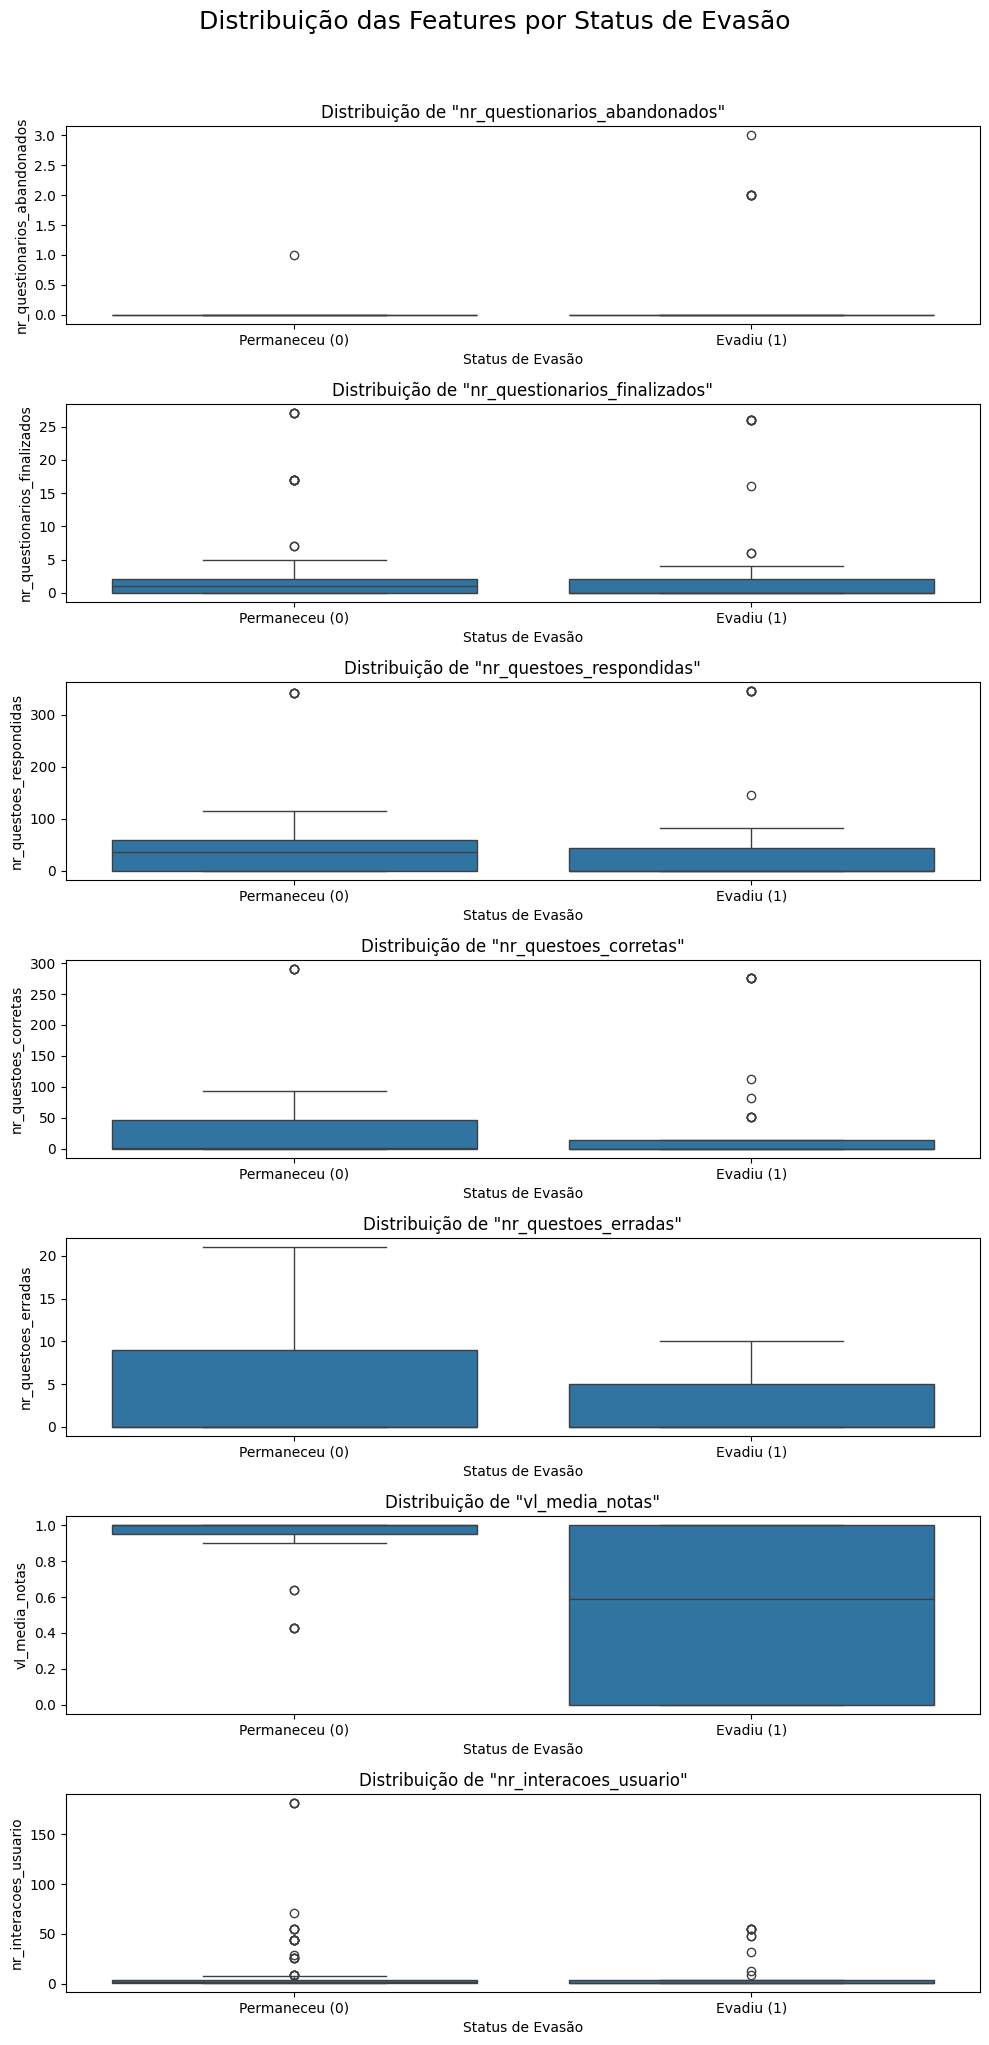

In [65]:
# Vamos usar as mesmas features de interesse que você analisou antes
features_interesse = [
    'nr_questionarios_abandonados', 
    'nr_questionarios_finalizados',
    'nr_questoes_respondidas',
    'nr_questoes_corretas',
    'nr_questoes_erradas',
    'vl_media_notas',
    'nr_interacoes_usuario'
  
]

# Adicionando a variável alvo ao DataFrame para usar no 'hue'
# (Criamos uma cópia para não alterar o DataFrame original)
df_plot = df_treino_final.copy()
df_plot['target_evadiu'] # Supondo que 'target_evadiu' seja sua Series com 0s e 1s

# Criando um boxplot para cada feature de interesse
fig, axes = plt.subplots(len(features_interesse), 1, figsize=(10, 20))
fig.suptitle('Distribuição das Features por Status de Evasão', fontsize=18, y=1.02)

for i, feature in enumerate(features_interesse):
    sns.boxplot(data=df_plot, x='target_evadiu', y=feature, ax=axes[i])
    axes[i].set_title(f'Distribuição de "{feature}"')
    axes[i].set_xticklabels(['Permaneceu (0)', 'Evadiu (1)'])
    axes[i].set_xlabel('Status de Evasão')

plt.tight_layout()
plt.show()

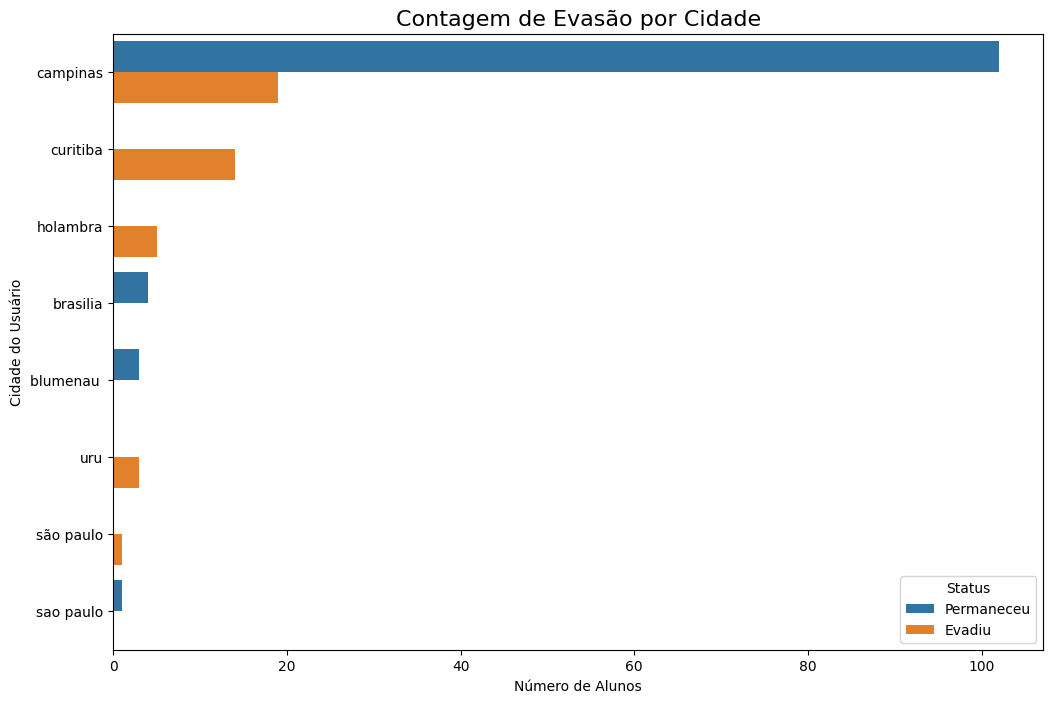

In [59]:
# Supondo que df_plot ainda contém a coluna 'target_evadiu'
plt.figure(figsize=(12, 8))
df_plot['ds_cidade_usuario'] = df_plot['ds_cidade_usuario'].str.lower()
# Usamos o countplot com 'hue' para separar por status de evasão
# Usar 'y' em vez de 'x' é bom para categorias com nomes longos
ax = sns.countplot(y='ds_cidade_usuario', hue='target_evadiu', data=df_plot, order = df_plot['ds_cidade_usuario'].value_counts().index)

plt.title('Contagem de Evasão por Cidade', fontsize=16)
plt.xlabel('Número de Alunos')
plt.ylabel('Cidade do Usuário')
plt.legend(title='Status', labels=['Permaneceu', 'Evadiu'])
plt.show()

Principais Descobertas: As features de maior impacto são as relacionadas à performance e interação direta do aluno, como o número de questões erradas e itens não respondidos, reforçando a nossa hipótese de que a falta de tentativa é um sinal mais forte de evasão do que o erro.

## **Etapa 4: Modelagem e Avaliação**

Com os dados refinados, partimos para a construção e comparação dos modelos. Utilizamos um pipeline para automatizar o pré-processamento e garantir a consistência, treinando três algoritmos para identificar o mais eficaz em capturar os padrões de engajamento.

In [ ]:
# ==============================================================================
# 4. MODELAGEM E AVALIAÇÃO
# ==============================================================================

# -- Separação dos Dados e Pipeline --
X = df_treino_final.drop(columns=['target_evadiu'])
y = df_treino_final['target_evadiu']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numerical_features), ('cat', categorical_transformer, categorical_features)])

# -- Treinamento e Avaliação --
print("Iniciando treinamento e avaliação dos modelos...")
def avaliar_modelo(y_real, y_pred, y_proba, nome_modelo):
    print(f"--- Avaliação: {nome_modelo} ---")
    print(f"  - Recall: {recall_score(y_real, y_pred):.4f}")
    print(f"  - F1-Score: {f1_score(y_real, y_pred):.4f}")
    print(f"  - AUC-ROC: {roc_auc_score(y_real, y_proba):.4f}\n")

# Modelo 1: Regressão Logística
pipeline_lr = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', LogisticRegression(random_state=42, max_iter=1000))])
pipeline_lr.fit(X_train, y_train)
y_pred_lr = pipeline_lr.predict(X_val); y_proba_lr = pipeline_lr.predict_proba(X_val)[:, 1]
avaliar_modelo(y_val, y_pred_lr, y_proba_lr, 'Regressão Logística')

# Modelo 2: Random Forest
pipeline_rf = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', RandomForestClassifier(random_state=42))])
pipeline_rf.fit(X_train, y_train)
y_pred_rf = pipeline_rf.predict(X_val); y_proba_rf = pipeline_rf.predict_proba(X_val)[:, 1]
avaliar_modelo(y_val, y_pred_rf, y_proba_rf, 'Random Forest')




Iniciando treinamento e avaliação dos modelos...
--- Avaliação: Regressão Logística ---
  - Recall: 0.5556
  - F1-Score: 0.7143
  - AUC-ROC: 0.8924

--- Avaliação: Random Forest ---
  - Recall: 0.8889
  - F1-Score: 0.8889
  - AUC-ROC: 0.9479



Dimensões do treino processado: (164, 31)
Dimensões da validação processada: (41, 31)

Arquitetura do Modelo:


Model: "rede_neural_evasao"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ camada_oculta_1 (Dense)         │ (None, 64)             │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ camada_oculta_2 (Dense)         │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ camada_de_saida (Dense)         │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,161 (16.25 KB)

 Trainable params: 4,161 (16.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - auc: 0.3351 - loss: 0.8002 - val_auc: 0.4583 - val_loss: 0.6870
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.4868 - loss: 0.8141 - val_auc: 0.5764 - val_loss: 0.6678
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.5415 - loss: 0.7003 - val_auc: 0.6719 - val_loss: 0.6449
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.6336 - loss: 0.6434 - val_auc: 0.7344 - val_loss: 0.6255
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.6224 - loss: 0.6551 - val_auc: 0.7743 - val_loss: 0.6075
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.5967 - loss: 0.7749 - val_auc: 0.8299 - val_loss: 0.5952
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.6277 - loss: 0.6502 - val_auc: 0.8576 - val_loss: 0.5831
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.6085 - loss: 0.6802 - val_auc: 0.8646 - val_loss: 0.5721
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.6813 - loss: 

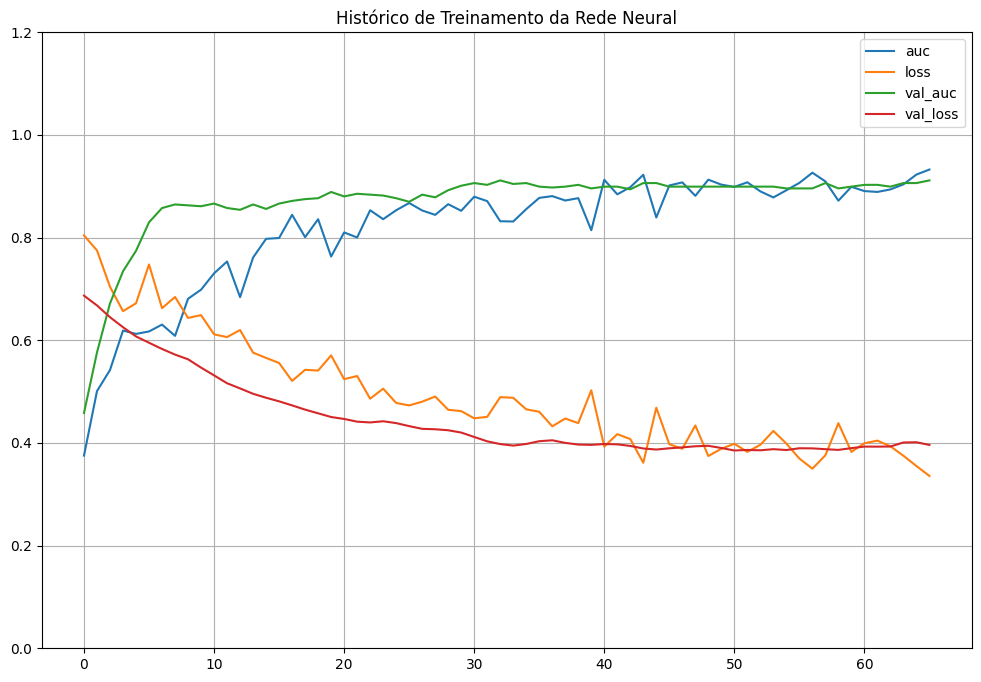


Avaliando o modelo final nos dados de validação...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Resultado Final - AUC: 0.8993 | F1-Score: 0.5833


In [ ]:
# Modelo 3: Rede Neural (Keras)
# Pré-processando os dados de treino e validação com o pipeline definido
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)

# Verificando as dimensões dos dados processados
print(f"Dimensões do treino processado: {X_train_processed.shape}")
print(f"Dimensões da validação processada: {X_val_processed.shape}")

# Definindo a arquitetura da Rede Neural
def build_keras_model(input_dim):
    """
    Cria e compila um modelo sequencial do Keras.
    """
    model = Sequential(name="rede_neural_evasao")
    
    # Adicionando as camadas ao modelo
    # Camada de Entrada: define o formato dos dados de entrada
    model.add(Input(shape=(input_dim,), name="camada_de_entrada"))
    
    # Camadas Ocultas: onde o aprendizado principal acontece
    model.add(Dense(64, activation='relu', name="camada_oculta_1"))
    model.add(Dropout(0.5, name="dropout_1")) # Camada de Dropout para regularização
    model.add(Dense(32, activation='relu', name="camada_oculta_2"))
    model.add(Dropout(0.3, name="dropout_2"))
    
    # Camada de Saída: para classificação binária, 1 neurônio com ativação 'sigmoid'
    model.add(Dense(1, activation='sigmoid', name="camada_de_saida"))
    
    # Compilando o modelo
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=[keras.metrics.AUC(name='auc')]
    )
    return model

# Construindo o modelo, passando apenas o número de features como input_dim
keras_model = build_keras_model(X_train_processed.shape[1])

# Exibindo um resumo da arquitetura do modelo
print("\nArquitetura do Modelo:")
keras_model.summary()

# Definindo callbacks
# EarlyStopping para o treinamento quando a perda de validação não melhora
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=15, 
    restore_best_weights=True,
    verbose=1
)

# Calculando pesos de classe para lidar com o desbalanceamento
neg, pos = np.bincount(y_train)
total = neg + pos
class_weight = {0: (1 / neg) * (total / 2.0), 1: (1 / pos) * (total / 2.0)}

# Treinando o modelo
history = keras_model.fit(
    X_train_processed,
    y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val_processed, y_val),
    callbacks=[early_stopping],
    class_weight=class_weight,
    verbose=1
)

# Plotando o histórico de treinamento
print("\nHistórico de Treinamento:")
pd.DataFrame(history.history).plot(figsize=(12, 8))
plt.grid(True)
plt.gca().set_ylim(0, 1.2)
plt.title("Histórico de Treinamento da Rede Neural")
plt.show()

# Avaliando o modelo Keras e adicionando aos resultados
print("\nAvaliando o modelo final nos dados de validação...")
val_loss, val_auc = keras_model.evaluate(X_val_processed, y_val, verbose=0)
y_pred_keras = (keras_model.predict(X_val_processed) > 0.5).astype("int32")
val_f1 = f1_score(y_val, y_pred_keras)

print(f"Resultado Final - AUC: {val_auc:.4f} | F1-Score: {val_f1:.4f}")
results={}
results['Rede Neural'] = {
    'Mean AUC': val_auc,
    'Std AUC': 'N/A',
    'Mean F1': val_f1,
    'Std F1': 'N/A'
}

O modelo Random Forest novamente se destacou, apresentando um excelente equilíbrio entre as métricas e sendo escolhido como nosso modelo final.

## **Etapa 5: Validação Final, Explicabilidade e Conclusão**

Na etapa final, validamos nosso modelo campeão no conjunto de teste e utilizamos XAI para entender suas decisões, confirmando o valor da nossa abordagem focada em engajamento.

--- DESEMPENHO FINAL DO MODELO DE ENGAJAMENTO (NO CONJUNTO DE TESTE) ---
--- Avaliação: Random Forest (Teste Final) ---
  - Recall: 0.9412
  - F1-Score: 0.9697
  - AUC-ROC: 0.9867



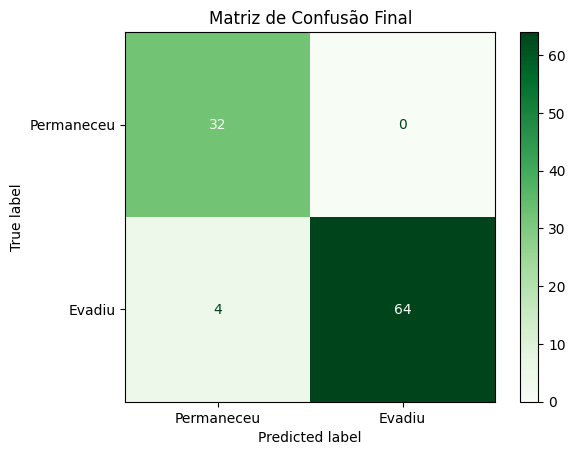


--- Explicabilidade do Modelo de Engajamento ---


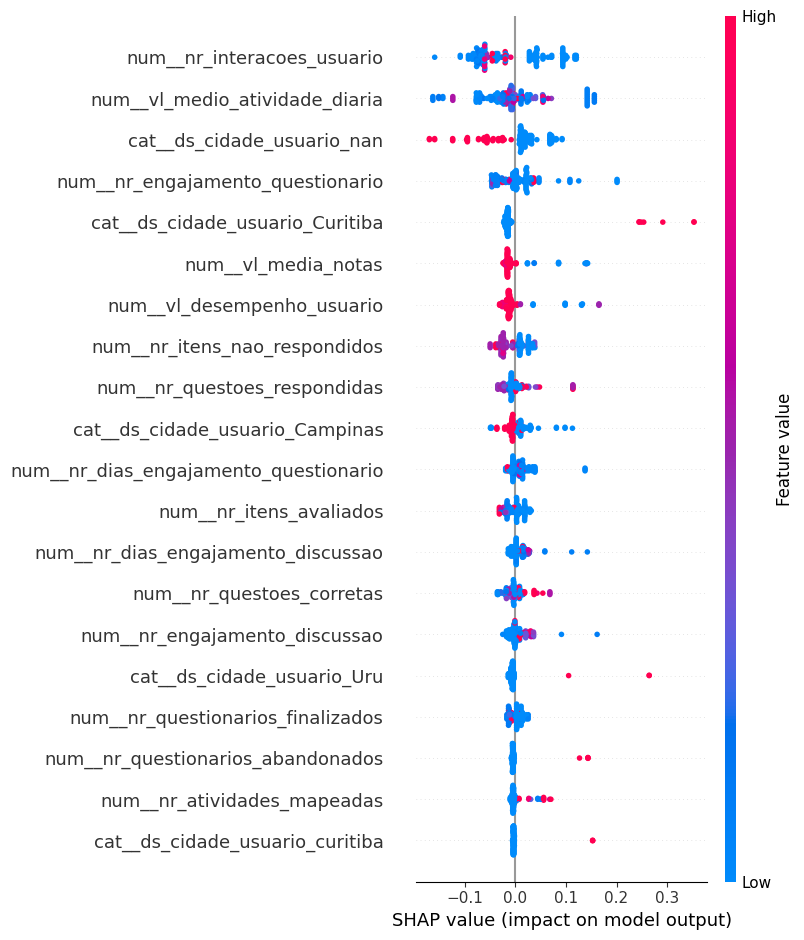


✅ Modelo final de engajamento salvo com sucesso em 'modelo_final_engajamento.joblib'


In [57]:
# ==============================================================================
# 5. VALIDAÇÃO FINAL, XAI E CONCLUSÃO
# ==============================================================================
# -- 5.1. Desempenho final no conjunto de teste --
X_teste = df_teste_final.drop(columns=['target_evadiu'])
y_teste = df_teste_final['target_evadiu']
y_pred_teste_rf = pipeline_rf.predict(X_teste)
y_proba_teste_rf = pipeline_rf.predict_proba(X_teste)[:, 1]
print("--- DESEMPENHO FINAL DO MODELO DE ENGAJAMENTO (NO CONJUNTO DE TESTE) ---")
avaliar_modelo(y_teste, y_pred_teste_rf, y_proba_teste_rf, 'Random Forest (Teste Final)')
cm = confusion_matrix(y_teste, y_pred_teste_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Permaneceu', 'Evadiu'])
disp.plot(cmap='Greens'); plt.title('Matriz de Confusão Final'); plt.show()

# -- 5.2. Explicabilidade com SHAP --
print("\n--- Explicabilidade do Modelo de Engajamento ---")
explainer = shap.TreeExplainer(pipeline_rf.named_steps['classifier'])
X_train_proc = preprocessor.fit_transform(X_train)
shap_values = explainer.shap_values(X_train_proc)
shap.summary_plot(shap_values[:, :, 1], X_train_proc, feature_names=preprocessor.get_feature_names_out())

# -- 5.3. Exportação do Modelo --
filename = 'modelo_final_engajamento.joblib'
joblib.dump(pipeline_rf, filename)
print(f"\n✅ Modelo final de engajamento salvo com sucesso em '{filename}'")

Nossa decisão estratégica de focar em variáveis de engajamento se provou correta. Construímos um modelo robusto que não só prevê a evasão com alta performance, mas também fornece insights claros e acionáveis para a equipe da PensComp. O gráfico SHAP confirma que o modelo baseia suas decisões em comportamentos reais dos alunos, como interações e respostas a atividades, que é exatamente o que a equipe pedagógica pode observar e influenciar. O modelo final está salvo e pronto para gerar valor.